In [49]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [50]:
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'ACC_X', 'ACC_Y', 'ACC_Z']
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# TODO ADD AUX WHEN CONNECTED
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink']
columns = channels + eye_data_names

data, header = pyxdf.load_xdf('data/data18022023/eeg-and-eyetracking.xdf')
print(header)

{'info': defaultdict(<class 'list'>, {'version': ['1'], 'notes': [None]})}


In [51]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False

    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end

def plot_eeg_blink_single(stream, start, end,column,rang = 50):
    y = stream['time_series']
    df = pd.DataFrame(y)
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(stream['time_stamps'][start], color='red')  # y = 0
    axis.axvline(stream['time_stamps'][end], color='red')
    axis.plot(stream['time_stamps'][start-rang:end+rang], df[column])
    axis.set_title(column)
    plt.show()

def plot_eeg_blink_all():
    pass

In [56]:
left_blinks = None
right_blinks = None
both_blink = None
stream = None
df_stream = None
df_stream_ts = None
for s in data:
    stream = s
    y = stream['time_series']
    df_stream = pd.DataFrame(y)
    df_stream_ts = pd.DataFrame(stream['time_stamps'])
    df_stream.columns = columns
    eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink']

    left_blinks = df_stream.index[(df_stream['left_blink'] >= 1) & (df_stream['right_blink'] != 1)].tolist()
    right_blinks = df_stream.index[(df_stream['right_blink'] >= 1) & (df_stream['left_blink'] != 1)].tolist()
    both_blink = df_stream.index[df_stream['both_blink'] == 1].tolist()



[139, 233, 352, 1893]
[160, 254, 368, 1894]


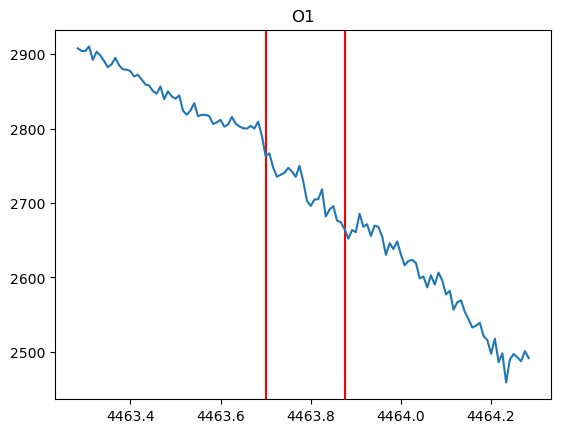

In [53]:
start, end = get_time_stamps(right_blinks)
print(start)
print(end)
plot_eeg_blink_single(stream, start[0], end[0], 'O1')